In [1]:
from __future__ import print_function
import sys, os
import time
import pickle
import rospy
import numpy as np
from scipy import signal
import scipy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# wrapper/helper functions
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
from torobo_rnn_utils__upd3 import *
from detect_upd import Recog, Recog2
from adjustExtForce_v3Controller import ExtForce

plt.switch_backend('nbAgg')

bridge = CvBridge()
torobo = ToroboOperator()
        
def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()
    
class NewRec(threading.Thread):

    """ RECORDS A DATASET FOR THE RNN """
    
    def __init__(self):
        threading.Thread.__init__(self)
        self.recording = False
        self.step = 0.1
        self.data = {}
        self.fname = "DS_mult.dat"
    
    def run(self):
        if self.recording == True:
            self.recording = False
            print('Killing the previous recorder')
            time.sleep(1.5)
        self.recording = True
        self.record()
    
    def stop(self):
        self.recording = False
        time.sleep(1)
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        
        self.data['img'] = np.stack(self.data['img'])
        self.data['joints'] = np.stack(self.data['joints'])
        self.data['t'] = np.stack(self.data['t'])
        with open(self.fname, 'wb') as f:
            pickle.dump(self.data, f)
        print('Data saved')

        
    def record(self):
        global torobo, imagebuff
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        # overwrite
        if self.fname in os.listdir("."):
            open(self.fname, 'w').close()
        t = 0
        start_t = time.time()
        self.data['joints'] = []
        self.data['img'] = []
        self.data['t'] = []
        while self.recording:
            self.data['joints'].append(np.radians(get_cur_joints(torobo)[0]))
            self.data['img'].append(cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA) )
            self.data['t'].append(time.time()-start_t)
            time.sleep(self.step)
            t += self.step

class Tracker(threading.Thread):
    """ - LOADS THE YOLO MODEL
        - FORWARD PASSES THE FRAME THROUGH THE MODEL
        - STORES BOUNDING BOX COORDINATES IN SELF.
    """
    
    def __init__(self):
        threading.Thread.__init__(self)
        
        checkpoint = 42
        self.recog = Recog2(checkpoint)
        
        self.x1, self.y1, self.x2, self.y2 = 0.0, 0.0, 0.0, 0.0
        self.new_hor = 0
        self.new_ver = 0
        self.Norm = scipy.stats.norm(0, 20)
        self.scale = self.Norm.pdf(0)
        
        self.keepgoing = False

    def stop(self):
        self.keepgoing = False

    def get_gaze_offset(self, cx, cy):
        return 640/2 - cx, 480/2 - cy
    
    def get_gaze_grad(self, offset_x, offset_y):
        ex = 0.2 * np.tanh(0.025*(offset_x))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        ey = 0.2 * np.tanh(0.025*(offset_y))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        return ex, ey

    def get_box_center(self, x1, y1, box_w, box_h):
        return x1 + box_w/2, y1 + box_h/2

    def track_obj(self, x,y,w,h):
        global torobo
        cx, cy = self.get_box_center(x, y, w, h)
        gaze_offset = self.get_gaze_offset(cx,cy)
        ex, ey = self.get_gaze_grad(*gaze_offset)
        hor, ver = get_cur_joints(torobo)[0][14:16]
        self.new_hor, self.new_ver = np.radians(hor)+ex, np.radians(ver)-ey

    def run(self):
        global imagebuff
        self.keepgoing = True
        while True and self.keepgoing:
            detections = self.recog.detect(imagebuff)
            if detections is not None:
                for det in detections:
                    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                        if cls_pred == 0:
                            box_w = x2 - x1
                            box_h = y2 - y1
                            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
                            x, y, w, h = x1, y1, box_w, box_h
                            self.track_obj(x, y, w, h)

In [61]:
with HiddenPrints():
    servo_on(torobo)

In [5]:
""" SET DYNAMICS PARAMETERS FOR THE ***POSITION*** REGIME  """
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
    time.sleep(1)

[INFO] [1593393538.877182]: set_control_mode service client is called
[INFO] [1593393538.882141]: set_control_mode [['all']] is succeeded
[INFO] [1593393538.882858]: set_control_mode service client is called
[INFO] [1593393538.885640]: set_control_mode [['all']] is succeeded
[INFO] [1593393538.886219]: set_control_mode service client is called
[INFO] [1593393538.888143]: set_control_mode [['all']] is succeeded


In [3]:
""" SET DYNAMICS PARAMETERS FOR THE ***EXTERNAL FORCE FOLLOWING*** REGIME  """
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following');
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following');

[INFO] [1594363628.491304]: set_control_mode service client is called
[INFO] [1594363628.493501]: set_control_mode [['all']] is succeeded
[INFO] [1594363628.493910]: set_control_mode service client is called
[INFO] [1594363628.495768]: set_control_mode [['all']] is succeeded


In [36]:
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'external_force_following');

[INFO] [1592736264.897881]: set_control_mode service client is called
[INFO] [1592736264.899658]: set_control_mode [['all']] is succeeded


In [41]:
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position');

[INFO] [1592736383.621894]: set_control_mode service client is called
[INFO] [1592736383.623950]: set_control_mode [['all']] is succeeded


In [8]:
""" SET DYNAMICS PARAMETERS FOR THE ***EXTERNAL FORCE FOLLOWING __ONLINE TRAJECTORY__ *** REGIME  """
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following_online_trajectory')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following_online_trajectory')
    time.sleep(1)

[INFO] [1591950979.370941]: set_control_mode service client is called
[INFO] [1591950979.373455]: set_control_mode [['all']] is succeeded
[INFO] [1591950979.373925]: set_control_mode service client is called
[INFO] [1591950979.375580]: set_control_mode [['all']] is succeeded


In [13]:
""" TURN ON VIDEOSTREAMING FROM THE ROBOT'S CAMERA """

SRATE = 10
""" REPLAY @ 5 HZ, RECORD AT 10 HZ """
INTERVAL = 0.2
tracking = True

##############################################################################################
# checkpoint = 42


try:
    with HiddenPrints():
        if not 'imagebuff' in locals():
            imagebuff = 0
            def image_callback(msg):
                global imagebuff
                imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
            rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

        torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following')
        torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
        torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
        time.sleep(1)
        set_velocity_override(torobo, 30.0)
        time.sleep(1)
    
    print('SUCCESS')
except:
    print('ERROR')

SUCCESS


In [14]:
SRATE = 10
TIME = 30
data_rec = NewRec()
data_rec.start()

t = time.time()
while time.time()-t < 30:
    try:
        echo('elapsed: {:.2f}'.format(time.time()-t))
        time.sleep(0.2)
    except:
        print('\nAborted')
        break
print('\n')
data_rec.stop()

 elapsed: 0.00N
 elapsed: 29.86

Recording is OFF
Data saved


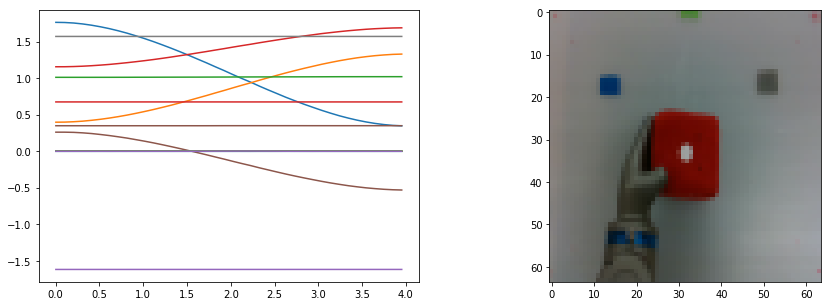

In [59]:
with open('traj 2.dat', 'rb') as f:
    dat = pickle.load(f)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
t = dat['t']
for i in range(16):
    x = dat['joints'][:,i]
    ax0.plot(t,x)
ax1.imshow(dat['img'][-1])

In [36]:
# rec target positions
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following')
target = np.radians(get_cur_joints(torobo)[0])

[INFO] [1594373888.072491]: set_control_mode service client is called
[INFO] [1594373888.077160]: set_control_mode [['all']] is succeeded


In [43]:
traj_idx = 0

In [44]:
# now move the hand away from the target. Repeat many times

In [54]:
# record one trajectory
DUR = 4
data_rec = NewRec()
data_rec.fname = 'traj {}.dat'.format(traj_idx)

torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
time.sleep(1.0)
data_rec.start()
left_arm_positions = target[0:6]
torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=DUR)
time.sleep(DUR)
data_rec.stop()
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following')
traj_idx += 1

[INFO] [1594375721.944702]: set_control_mode service client is called
[INFO] [1594375721.947008]: set_control_mode [['all']] is succeeded
Recording is ON
Recording is OFF
Data saved
[INFO] [1594375727.970318]: set_control_mode service client is called
[INFO] [1594375727.971877]: set_control_mode [['all']] is succeeded


In [19]:
import cv2
import numpy as np
import time
import pickle


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


i = 1

while True:
    try:
        time.sleep(0.1)
        img = imagebuff.astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break

In [6]:
data_rec.stop()

Recording is OFF


In [2]:
move_homepos(torobo)

Moving to home position
[INFO] [1593393320.459031, 316.790000]: set_control_mode service client is called
[INFO] [1593393320.463709, 316.795000]: Service call failed: service [/torobo/left_arm_controller/set_control_mode] unavailable
[INFO] [1593393320.464003, 316.795000]: set_control_mode service client is called
[INFO] [1593393320.465401, 316.796000]: Service call failed: service [/torobo/right_arm_controller/set_control_mode] unavailable
[INFO] [1593393320.465775, 316.797000]: set_control_mode service client is called
[INFO] [1593393320.466900, 316.798000]: Service call failed: service [/torobo/torso_head_controller/set_control_mode] unavailable
[INFO] [1593393320.467147, 316.798000]: set_control_mode service client is called
[INFO] [1593393320.468103, 316.799000]: Service call failed: service [/torobo/left_gripper_controller/set_control_mode] unavailable
[INFO] [1593393320.468401, 316.799000]: set_control_mode service client is called
[INFO] [1593393320.469914, 316.801000]: Service

##########################################################################################################
# COLLECT WAYPOINTS    
########################################################################################################## 

In [37]:
RAD = []

In [71]:
##########################################################################################################
### COLLECT WAYPOINTS    #################################################################################
##########################################################################################################

cur_pos_deg, _ = get_cur_joints(torobo)
cur_pos_rad = array_radians(cur_pos_deg)

RAD.append(cur_pos_rad)

In [112]:
print(len(RAD))
with open('rad.pickle', 'wb') as f:
    pickle.dump(RAD, f)

11


In [6]:
len(RAD)

11

##########################################################################################################
# REPLAY THE WAYPOINTS 
##########################################################################################################

In [16]:
# START DENSE RECORDING (POSITIONS AND TORQUES)

SRATE = 10
data_rec = Recorder(torobo, '', SRATE)
r = rospy.Rate(SRATE) # Hz
data_rec.start()
time.sleep(1.5)
MODE = 'position'  # ['position', 'external_force_following_online_trajectory']
TIME = 5
# set_dynamics_params(dyn_params_hard)
time.sleep(2)

set_softness_override(torobo, 30.0)
set_velocity_override(torobo, 30.0)
time.sleep(1)

torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', MODE)
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', MODE)
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
time.sleep(2.0)

Recording is ON
[INFO] [1593405520.797319]: set_robot_controller_parameter service client is called
[INFO] [1593405520.799036]: set [softness_override, ['30.0'], ['all']] is succeeded
[INFO] [1593405520.799312]: set_robot_controller_parameter service client is called
[INFO] [1593405520.800882]: set [softness_override, ['30.0'], ['all']] is succeeded
[INFO] [1593405520.801202]: set_robot_controller_parameter service client is called
[INFO] [1593405520.802578]: set [softness_override, ['30.0'], ['all']] is succeeded
[INFO] [1593405520.802878]: set_robot_controller_parameter service client is called
[INFO] [1593405520.804263]: set [velocity_override, ['30.0'], ['all']] is succeeded
[INFO] [1593405520.804528]: set_robot_controller_parameter service client is called
[INFO] [1593405520.806123]: set [velocity_override, ['30.0'], ['all']] is succeeded
[INFO] [1593405520.806408]: set_robot_controller_parameter service client is called
[INFO] [1593405520.807808]: set [velocity_override, ['30.0']

In [17]:
with open('rad.pickle', 'rb') as f:
    RAD = pickle.load(f)
ANG = []
ts = time.time()

In [27]:
idx = 0
TIME = 1

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 1
TIME = 2

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 2
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 3
TIME = 4

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 4
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

In [41]:
idx = 4
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

In [7]:
# times = [4, 2, 2]
# IDX = [8, 9, 10]

# for idx, TIME in zip(IDX, times):

#     left_arm_positions = RAD[idx][0:6]
#     right_arm_positions = RAD[idx][6:12]
#     torso_head_positions = RAD[idx][12:16]

#     torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#     rospy.sleep(TIME+0.02)
#     ANG.append((idx, time.time() - ts))

In [17]:
# IDX = [9, 8, 4]
# times = [2, 2, 4]
# for idx, TIME in zip(IDX, times):

#     left_arm_positions = RAD[idx][0:6]
#     right_arm_positions = RAD[idx][6:12]
#     torso_head_positions = RAD[idx][12:16]

#     torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#     rospy.sleep(TIME+0.02)
#     ANG.append((idx, time.time() - ts))

In [18]:
for repeat in range(6):
#     times = [2, 1.5, 0.5, 0.5, 2, 2]
#     IDX = [5, 6, 7, 8, 9, 10]

#     times = [3.5, 0.5, 2, 2]
#     IDX = [6, 8, 9, 10]
    times = [4, 2, 2]
    IDX = [8, 9, 10]

    for idx, TIME in zip(IDX, times):

        left_arm_positions = RAD[idx][0:6]
        right_arm_positions = RAD[idx][6:12]
        torso_head_positions = RAD[idx][12:16]

        torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
        rospy.sleep(TIME+0.02)
        ANG.append((idx, time.time() - ts))

    IDX = [9, 8, 4]
    times = [2, 2, 4]
    for idx, TIME in zip(IDX, times):

        left_arm_positions = RAD[idx][0:6]
        right_arm_positions = RAD[idx][6:12]
        torso_head_positions = RAD[idx][12:16]

        torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
        rospy.sleep(TIME+0.02)
        ANG.append((idx, time.time() - ts))

In [4]:
idx = 4
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 3
TIME = 4

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 2
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 1
TIME = 3

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

idx = 0
TIME = 2

left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)
ANG.append((idx, time.time() - ts))

In [19]:
data_rec.stop()
time.sleep(2)
del(data_rec)

Recording is OFF


In [1]:
""" SET DYNAMICS PARAMETERS FOR THE ***EXTERNAL FORCE FOLLOWING*** REGIME  """
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following');
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following');

NameError: name 'torobo' is not defined

In [5]:
# with open('rad.pickle', 'rb') as f:
#     RAD = pickle.load(f)

# # go to the get-ready position:
# for idx in [1,2,3]:
#     left_arm_positions = RAD[idx][0:6]
#     right_arm_positions = RAD[idx][6:12]
#     torso_head_positions = RAD[idx][12:16]

#     torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#     rospy.sleep(TIME+0.1)

In [6]:
# for trial in range(4):
#     # Reach and lift the cube:
#     for idx in [4,5]:
#         left_arm_positions = RAD[idx][0:6]
#         right_arm_positions = RAD[idx][6:12]
#         torso_head_positions = RAD[idx][12:16]
#         torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#         torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
#         torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#         rospy.sleep(TIME+0.1)

#     # put the cube back
#     for idx in [4, 3]:
#         left_arm_positions = RAD[idx][0:6]
#         right_arm_positions = RAD[idx][6:12]
#         torso_head_positions = RAD[idx][12:16]
#         torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#         torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
#         torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#         rospy.sleep(TIME+0.1)

In [7]:
# # go home from the get-ready position
# for idx in reversed(range(3)):
#     left_arm_positions = RAD[idx][0:6]
#     right_arm_positions = RAD[idx][6:12]
#     torso_head_positions = RAD[idx][12:16]
#     torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
#     torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
#     rospy.sleep(TIME+0.1)
# move_homepos(torobo)

# data_rec.stop()
# time.sleep(2)
# del(data_rec)

Moving to home position
Recording is OFF


#####################################################################################################
# PLOT THE DENSELY RECORDED TRAJECTORIES AND TORQUES:
#####################################################################################################

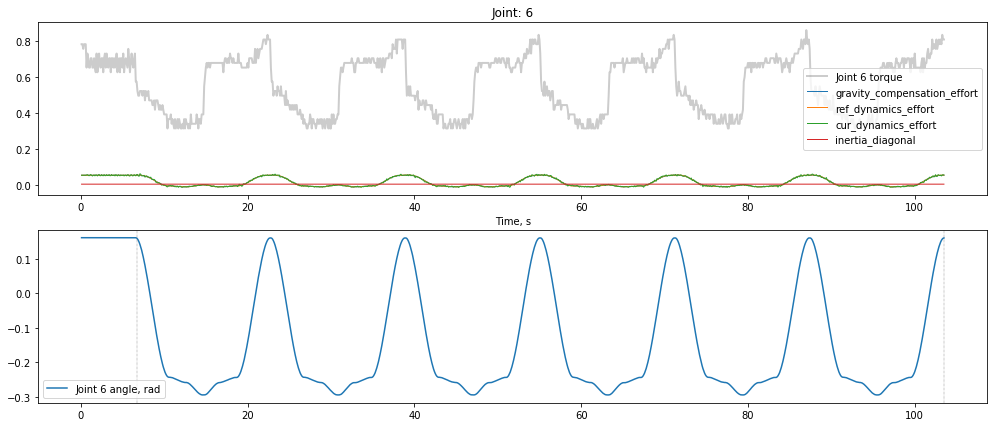

In [42]:
%matplotlib inline
# PLOT THE DENSELY RECORDED TRAJECTORIES AND TORQUES:

fname = "./joints/motor_rad_"+ "angtor"+".txt"
DAT0 = []
with open(fname) as f:
    for line in f:
        data = [float(i) for i in line.split('\t')]
        DAT0.append(data)
DAT0 = np.stack(DAT0)
DAT0 = np.delete(DAT0, 0, axis=0)

fname = "EFF.dat"
DAT1 = []
with open(fname) as f:
    for line in f:
        data = [float(i) for i in line.split('\t')]
        DAT1.append(data)
DAT1 = np.stack(DAT1)
DAT1 = np.delete(DAT1, 0, axis=0)

plt.figure(figsize=(17,7))
plt.subplot(2,1,1)
disps = {'left arm angles': 0,
         'right arm': 6,
         'left arm torque': 16,
         'right arm torque': 22}

joint = 5

disp = disps['left arm angles']
# plt.plot(DAT0[:,-1], DAT0[:,joint+disp]/np.pi, label='Joint {} angle'.format(joint+1))
disp = disps['left arm torque']
plt.plot(DAT0[:,-1], DAT0[:,joint+disp], linewidth=2, alpha=0.2, c='black', label='Joint {} torque'.format(joint+1))

plt.plot(DAT1[:,-1], DAT1[:,joint], linewidth=1, alpha=1, label='gravity_compensation_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+6], linewidth=1, alpha=1, label='ref_dynamics_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+2*6], linewidth=1, alpha=1, label='cur_dynamics_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+3*6], linewidth=1, alpha=1, label='inertia_diagonal')

plt.xlabel('Time, s')
plt.legend()
plt.title('Joint: {}'.format(joint+1))


plt.subplot(2,1,2)

disps = {'left arm angles': 0,
         'right arm': 6,
         'left arm torque': 16,
         'right arm torque': 22}

disp = disps['left arm angles']
plt.plot(DAT0[:,-1], DAT0[:,joint+disp]/np.pi, label='Joint {} angle, rad'.format(joint+1))
plt.legend()

plt.axvline(6.8, c='grey', linestyle='-.', linewidth=0.4)
plt.axvline(103.5, c='grey', linestyle='-.', linewidth=0.4)
# for i in ANG:
#     plt.axvline(i[1])
#     plt.text(i[1], 0.1, str(i[0]))
    

##########################################################################################################
# REPLAY THE DENSE TRAJECTORY in the TEACHING mode 
##########################################################################################################

In [48]:
tt = time.time()
"""
REPLAY THE TRAJECTORY
"""

start_t = 6.8
stop_t = 103.5

start_idx = np.abs(DAT[:,-1] - start_t).argmin()
stop_idx = np.abs(DAT[:,-1] - stop_t).argmin()
print(start_idx, stop_idx)

start = time.time()

zero_vel = [0.0 for i in range(ALL_JOINTS)]

if tracking:
    tracker = Tracker()
    tracker.start()
    time.sleep(0.2)

newrec = NewRec()
newrec.start()
time.sleep(0.2)

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

for i in range(start_idx, stop_idx):
    
    start_time = rospy.get_time()
    
    left_arm_positions = DAT[i, 0:6]
    right_arm_positions = DAT[i, 6:12]
    torso_only_positions = DAT[i, 12:14]
    if tracking:
        hor, ver = tracker.new_hor, tracker.new_ver
    
    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=INTERVAL)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=INTERVAL)
    if tracking:
        torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                              joint_ids = [0, 1, 2, 3],
                              positions=[torso_only_positions[0],torso_only_positions[1], hor, ver],
                              velocities=None,
                              accelerations=None,
                              duration=0.5)
    
    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break


    timePassed = (rospy.get_time() - start_time)
    if timePassed < 0.0:
         cumSleepTime -= timePassed
    else:
         cumSleepTime = 0.0

    sleep_time = INTERVAL - timePassed + cumSleepTime

    print("time passed: ", timePassed, " sleepTime: ", sleep_time)
    if(sleep_time  > 0.0):
        rospy.sleep(sleep_time)

print(time.time() - tt)
cv2.destroyWindow('I see')

newrec.stop()
if tracking:
    tracker.stop()

67 1034
Recording is ON
time passed:  0.0229649543762  sleepTime:  0.177035045624
time passed:  0.0304758548737  sleepTime:  0.169524145126
time passed:  0.0115871429443  sleepTime:  0.188412857056
time passed:  0.0123870372772  sleepTime:  0.187612962723
time passed:  0.0128779411316  sleepTime:  0.187122058868
time passed:  0.0214219093323  sleepTime:  0.178578090668
time passed:  0.0134210586548  sleepTime:  0.186578941345
time passed:  0.0117478370667  sleepTime:  0.188252162933
time passed:  0.012442111969  sleepTime:  0.187557888031
time passed:  0.0118219852448  sleepTime:  0.188178014755
time passed:  0.0122570991516  sleepTime:  0.187742900848
time passed:  0.0110261440277  sleepTime:  0.188973855972
time passed:  0.0124428272247  sleepTime:  0.187557172775
time passed:  0.0120491981506  sleepTime:  0.187950801849
time passed:  0.0106818675995  sleepTime:  0.189318132401
time passed:  0.0115990638733  sleepTime:  0.188400936127
time passed:  0.0118930339813  sleepTime:  0.1881

time passed:  0.0105860233307  sleepTime:  0.189413976669
time passed:  0.0132207870483  sleepTime:  0.186779212952
time passed:  0.0128378868103  sleepTime:  0.18716211319
time passed:  0.0111699104309  sleepTime:  0.188830089569
time passed:  0.0138409137726  sleepTime:  0.186159086227
time passed:  0.0118179321289  sleepTime:  0.188182067871
time passed:  0.0112960338593  sleepTime:  0.188703966141
time passed:  0.0123188495636  sleepTime:  0.187681150436
time passed:  0.0111718177795  sleepTime:  0.18882818222
time passed:  0.0109729766846  sleepTime:  0.189027023315
time passed:  0.010537147522  sleepTime:  0.189462852478
time passed:  0.015389919281  sleepTime:  0.184610080719
time passed:  0.0128989219666  sleepTime:  0.187101078033
time passed:  0.014151096344  sleepTime:  0.185848903656
time passed:  0.0147309303284  sleepTime:  0.185269069672
time passed:  0.0129539966583  sleepTime:  0.187046003342
time passed:  0.0124051570892  sleepTime:  0.187594842911
time passed:  0.010

time passed:  0.0134010314941  sleepTime:  0.186598968506
time passed:  0.0106899738312  sleepTime:  0.189310026169
time passed:  0.0131340026855  sleepTime:  0.186865997314
time passed:  0.0135130882263  sleepTime:  0.186486911774
time passed:  0.0119540691376  sleepTime:  0.188045930862
time passed:  0.0107469558716  sleepTime:  0.189253044128
time passed:  0.012638092041  sleepTime:  0.187361907959
time passed:  0.0107128620148  sleepTime:  0.189287137985
time passed:  0.0125830173492  sleepTime:  0.187416982651
time passed:  0.0125339031219  sleepTime:  0.187466096878
time passed:  0.0134789943695  sleepTime:  0.18652100563
time passed:  0.0129549503326  sleepTime:  0.187045049667
time passed:  0.0128371715546  sleepTime:  0.187162828445
time passed:  0.010938167572  sleepTime:  0.189061832428
time passed:  0.0139620304108  sleepTime:  0.186037969589
time passed:  0.0138049125671  sleepTime:  0.186195087433
time passed:  0.0121510028839  sleepTime:  0.187848997116
time passed:  0.0

time passed:  0.0125951766968  sleepTime:  0.187404823303
time passed:  0.0131750106812  sleepTime:  0.186824989319
time passed:  0.011599779129  sleepTime:  0.188400220871
time passed:  0.0140299797058  sleepTime:  0.185970020294
time passed:  0.0123469829559  sleepTime:  0.187653017044
time passed:  0.0122439861298  sleepTime:  0.18775601387
time passed:  0.0133080482483  sleepTime:  0.186691951752
time passed:  0.0135679244995  sleepTime:  0.1864320755
time passed:  0.0131158828735  sleepTime:  0.186884117126
time passed:  0.01229596138  sleepTime:  0.18770403862
time passed:  0.013594865799  sleepTime:  0.186405134201
time passed:  0.0171639919281  sleepTime:  0.182836008072
time passed:  0.0119140148163  sleepTime:  0.188085985184
time passed:  0.0137610435486  sleepTime:  0.186238956451
time passed:  0.0109260082245  sleepTime:  0.189073991776
time passed:  0.0117049217224  sleepTime:  0.188295078278
time passed:  0.0113649368286  sleepTime:  0.188635063171
time passed:  0.011492

time passed:  0.010822057724  sleepTime:  0.189177942276
time passed:  0.0132970809937  sleepTime:  0.186702919006
time passed:  0.0116670131683  sleepTime:  0.188332986832
time passed:  0.0116100311279  sleepTime:  0.188389968872
time passed:  0.0119280815125  sleepTime:  0.188071918488
time passed:  0.0123510360718  sleepTime:  0.187648963928
time passed:  0.0135090351105  sleepTime:  0.18649096489
time passed:  0.0124251842499  sleepTime:  0.18757481575
time passed:  0.0130920410156  sleepTime:  0.186907958984
time passed:  0.013561964035  sleepTime:  0.186438035965
time passed:  0.0132839679718  sleepTime:  0.186716032028
time passed:  0.0113968849182  sleepTime:  0.188603115082
time passed:  0.0133929252625  sleepTime:  0.186607074738
time passed:  0.0118730068207  sleepTime:  0.188126993179
time passed:  0.012866973877  sleepTime:  0.187133026123
time passed:  0.013482093811  sleepTime:  0.186517906189
time passed:  0.0104379653931  sleepTime:  0.189562034607
time passed:  0.0135

time passed:  0.0140678882599  sleepTime:  0.18593211174
time passed:  0.0115530490875  sleepTime:  0.188446950912
time passed:  0.0121438503265  sleepTime:  0.187856149673
time passed:  0.0145699977875  sleepTime:  0.185430002213
time passed:  0.012659072876  sleepTime:  0.187340927124
time passed:  0.0134520530701  sleepTime:  0.18654794693
time passed:  0.0119731426239  sleepTime:  0.188026857376
time passed:  0.0139429569244  sleepTime:  0.186057043076
time passed:  0.012727022171  sleepTime:  0.187272977829
time passed:  0.0142889022827  sleepTime:  0.185711097717
time passed:  0.0145750045776  sleepTime:  0.185424995422
time passed:  0.0151150226593  sleepTime:  0.184884977341
time passed:  0.0153210163116  sleepTime:  0.184678983688
time passed:  0.0130739212036  sleepTime:  0.186926078796
time passed:  0.0121347904205  sleepTime:  0.187865209579
time passed:  0.0138370990753  sleepTime:  0.186162900925
time passed:  0.0122451782227  sleepTime:  0.187754821777
time passed:  0.01

time passed:  0.0116600990295  sleepTime:  0.18833990097
time passed:  0.0098340511322  sleepTime:  0.190165948868
time passed:  0.0125679969788  sleepTime:  0.187432003021
time passed:  0.0133512020111  sleepTime:  0.186648797989
time passed:  0.0135900974274  sleepTime:  0.186409902573
time passed:  0.0118300914764  sleepTime:  0.188169908524
time passed:  0.0104539394379  sleepTime:  0.189546060562
time passed:  0.0109801292419  sleepTime:  0.189019870758
time passed:  0.010241985321  sleepTime:  0.189758014679
time passed:  0.0108361244202  sleepTime:  0.18916387558
time passed:  0.0120680332184  sleepTime:  0.187931966782
time passed:  0.0130100250244  sleepTime:  0.186989974976
time passed:  0.0130851268768  sleepTime:  0.186914873123
time passed:  0.0138568878174  sleepTime:  0.186143112183
time passed:  0.015172958374  sleepTime:  0.184827041626
time passed:  0.01509308815  sleepTime:  0.18490691185
time passed:  0.0118749141693  sleepTime:  0.188125085831
time passed:  0.01195

In [3]:
""" CONCATENATE MULTIPLE DATASET FILES (MUST START WITH DS...) """

dat_img, dat_joints, dat_t = [],[],[]
DS = {}
for DS_file in os.listdir('.'):
    if DS_file.startswith('DS'):
        with open(DS_file,'rb') as f:
            dat = pickle.load(f)
            dat_img.append(dat['img'])
            dat_joints.append(dat['joints'])
            dat_t.append(dat['t'])
DS['img'] = np.concatenate(dat_img, axis=0)
DS['joints'] = np.concatenate(dat_joints, axis=0)
DS['t'] = np.concatenate(dat_t, axis=0)

with open('DS.dat', 'wb') as f:
    pickle.dump(DS, f)

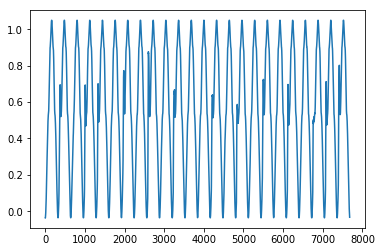

In [50]:
plt.plot(DS['joints'][:, 0])

In [51]:
DS['joints'].shape

(5739, 16)

In [35]:
np.concatenate((dat['img'], dat['img'])).shape

(3826, 64, 64, 3)

In [5]:
from scipy.stats import norm

In [11]:
""" GET REAL-TIME POSTITION UPDATES FROM THE TRACKER OBJECT """
for i in range(100):
    print('\r', tracker.new_hor, tracker.new_ver, end='')
    time.sleep(0.1)

 -0.3766955648673088 0.5373437437018298-0.3766955648673088 0.5373437437018298

In [6]:
import cv2
import numpy as np
import time
import pickle

with open('DS.dat', 'rb') as f:
    dat = pickle.load(f)
    
cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (40,40)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

i = 1

while True:
    try:
        time.sleep(0.1)
        img = dat['img'][i,:,:,:].astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.putText(img, str(i), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)

        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break

<IPython.core.display.Javascript object>


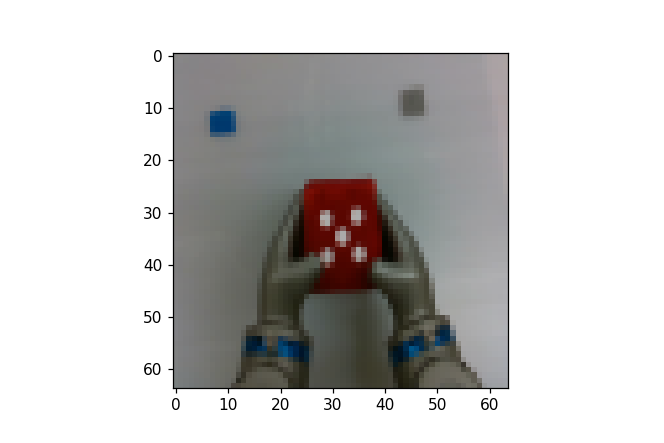

In [9]:
plt.imshow(dat['img'][300,:,:,:])

In [3]:
move_homepos(torobo)

Moving to home position
[INFO] [1592911466.360257, 69.182000]: set_control_mode service client is called
[INFO] [1592911466.364647, 69.186000]: Service call failed: service [/torobo/left_arm_controller/set_control_mode] unavailable
[INFO] [1592911466.365199, 69.186000]: set_control_mode service client is called
[INFO] [1592911466.366854, 69.189000]: Service call failed: service [/torobo/right_arm_controller/set_control_mode] unavailable
[INFO] [1592911466.367172, 69.189000]: set_control_mode service client is called
[INFO] [1592911466.368393, 69.191000]: Service call failed: service [/torobo/torso_head_controller/set_control_mode] unavailable
[INFO] [1592911466.368697, 69.191000]: set_control_mode service client is called
[INFO] [1592911466.370039, 69.192000]: Service call failed: service [/torobo/left_gripper_controller/set_control_mode] unavailable
[INFO] [1592911466.370470, 69.193000]: set_control_mode service client is called
[INFO] [1592911466.371692, 69.194000]: Service call fail

In [4]:
""" SET DYNAMICS PARAMETERS FOR THE ***POSITION*** REGIME  """
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
time.sleep(1)

with open('DS.dat', 'rb') as f:
    dat = pickle.load(f)

for i in range(1000):
    left_arm_positions = dat['joints'][i, 0:6]
    right_arm_positions = dat['joints'][i, 6:12]
    torso_head_positions = dat['joints'][i, 12:16]

    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=0.5)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=0.5)
    torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=0.5)
    time.sleep(0.1)

[INFO] [1592911483.278935, 86.083000]: set_control_mode service client is called
[INFO] [1592911483.280592, 86.089000]: Service call failed: service [/torobo/torso_head_controller/set_control_mode] unavailable
[INFO] [1592911483.281147, 86.090000]: set_control_mode service client is called
[INFO] [1592911483.282205, 86.091000]: Service call failed: service [/torobo/left_arm_controller/set_control_mode] unavailable
[INFO] [1592911483.282621, 86.091000]: set_control_mode service client is called
[INFO] [1592911483.283846, 86.093000]: Service call failed: service [/torobo/right_arm_controller/set_control_mode] unavailable


KeyboardInterrupt: 

In [17]:
""" Troubleshoot object fixation """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

t1, t2 = get_cur_joints(torobo)[0][12:14]

recog = Recog2(42)

if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

Norm = scipy.stats.norm(0, 20)
scale = Norm.pdf(0)

def get_gaze_offset(cx, cy):
    return 640/2 - cx, 480/2 - cy

def get_gaze_grad(offset_x, offset_y):
    global Norm, scale
    ex = 0.2 * np.tanh(0.025*(offset_x))/ (1+Norm.pdf(offset_x)/scale*4)
    ey = 0.2 * np.tanh(0.025*(offset_y))/ (1+Norm.pdf(offset_x)/scale*4)
    return ex, ey

def get_box_center(x1, y1, box_w, box_h):
    return x1 + box_w/2, y1 + box_h/2

def DetectAndTrack_2():
    global recog, imagebuff, torobo, imdump, c
    detections = recog.detect(imagebuff)

    hor, ver = get_cur_joints(torobo)[0][14:16]

    if detections is not None:
        for det in detections:
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                if cls_pred == 0:
                    box_w = x2 - x1
                    box_h = y2 - y1

                    imdump[c,:,:,:] = np.copy(imagebuff)
                    c += 1

                    image = cv2.rectangle(imagebuff, (x1,y1), (x2,y2), (255, 0, 0), 3)
                    x, y, w, h = x1, y1, box_w, box_h
                    cx, cy = get_box_center(x, y, w, h)
                    gaze_offset = get_gaze_offset(cx,cy)
                    ex, ey = get_gaze_grad(*gaze_offset) 
                    return np.radians(hor)+ex, np.radians(ver)-ey
    return np.radians(hor), np.radians(ver)

while True:
    time.sleep(0.1)
    hor, ver = DetectAndTrack_2()
    torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                          joint_ids = [0, 1, 2, 3],
                          positions=[t1, t2, hor, ver],
                          velocities=None,
                          accelerations=None,
                          duration=0.5)

    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break

NameError: global name 'imdump' is not defined

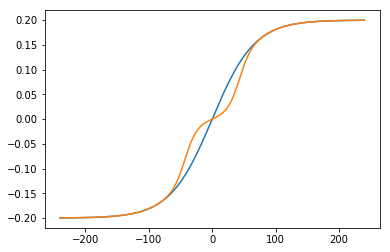

In [55]:
""" Neck motor response """

n = scipy.stats.norm(0, 20)
scale = n.pdf(0)
offset_x = np.linspace(-240, 240, 481)
y = 0.2 * np.tanh(0.015*(offset_x))
y1 = 0.2 * np.tanh(0.015*(offset_x)) / (1+n.pdf(offset_x)/scale*4)
plt.plot(offset_x,y)
plt.plot(offset_x,y1)

<p style="font-size:45px; color:magenta"> new recorder </p>

In [5]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    try:
        time.sleep(0.1)

        image = cv2.rectangle(tracker.imagebuff, (tracker.x1, tracker.y1), (tracker.x2, tracker.y2), (255, 0, 0), 3)
        cv2.imshow('I see', cv2.cvtColor(tracker.imagebuff, cv2.COLOR_RGB2BGR))
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break

#####################################################################################################
# PLOT THE DENSELY RECORDED TRAJECTORIES AND TORQUES:
#####################################################################################################

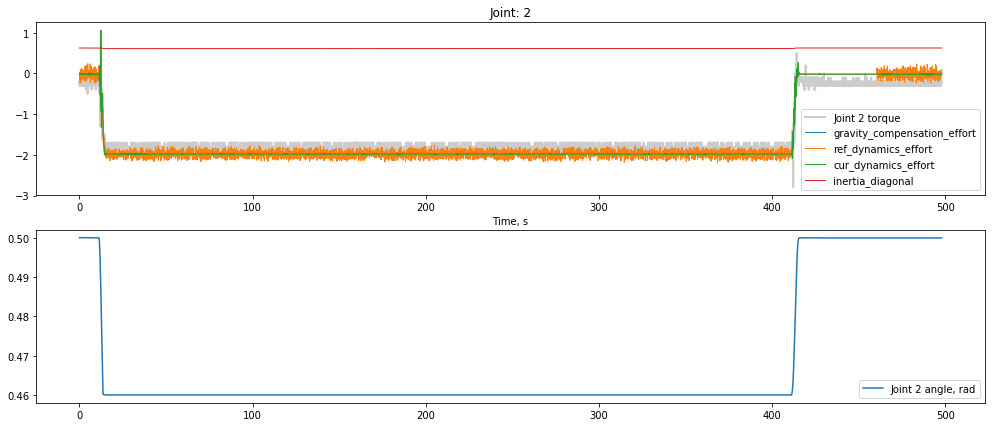

In [62]:
# PLOT THE DENSELY RECORDED TRAJECTORIES AND TORQUES:

fname = "./joints/motor_rad_"+ "angtorA"+".txt"

DAT0 = []
with open(fname) as f:
    for line in f:
        data = [float(i) for i in line.split('\t')]
        DAT0.append(data)
DAT0 = np.stack(DAT0)
DAT0 = np.delete(DAT0, 0, axis=0)

fname = "EFFA.dat"
DAT1 = []
with open(fname) as f:
    for line in f:
        data = [float(i) for i in line.split('\t')]
        DAT1.append(data)
DAT1 = np.stack(DAT1)
DAT1 = np.delete(DAT1, 0, axis=0)

plt.figure(figsize=(17,7))
plt.subplot(2,1,1)
disps = {'left arm angles': 0,
         'right arm': 6,
         'left arm torque': 16,
         'right arm torque': 22}

joint = 1

disp = disps['left arm angles']
# plt.plot(DAT0[:,-1], DAT0[:,joint+disp]/np.pi, label='Joint {} angle'.format(joint+1))
disp = disps['left arm torque']
plt.plot(DAT0[:,-1], DAT0[:,joint+disp], linewidth=2, alpha=0.2, c='black', label='Joint {} torque'.format(joint+1))

plt.plot(DAT1[:,-1], DAT1[:,joint], linewidth=1, alpha=1, label='gravity_compensation_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+6], linewidth=1, alpha=1, label='ref_dynamics_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+2*6], linewidth=1, alpha=1, label='cur_dynamics_effort')
plt.plot(DAT1[:,-1],DAT1[:,joint+3*6], linewidth=1, alpha=1, label='inertia_diagonal')

plt.xlabel('Time, s')
plt.legend()
plt.title('Joint: {}'.format(joint+1))


plt.subplot(2,1,2)

disps = {'left arm angles': 0,
         'right arm': 6,
         'left arm torque': 16,
         'right arm torque': 22}

disp = disps['left arm angles']
plt.plot(DAT0[:,-1], DAT0[:,joint+disp]/np.pi, label='Joint {} angle, rad'.format(joint+1))
plt.legend()

##########################################################################################################
# REPLAY THE DENSE TRAJECTORY RECORDED IN THE HUMAN-ASSISTED MODE   
##########################################################################################################

In [31]:
set_position_control(torobo)

SRATE = 10

fname = "./joints/motor_rad_"+ "angtorA"+".txt"
DAT = []
with open(fname) as f:
    for line in f:
        data = [float(i) for i in line.split('\t')]
        DAT.append(data)
DAT = np.stack(DAT)
DAT = np.delete(DAT, 0, axis=0)

# set_velocity_override(torobo, 100.0)
# set_softness_override(torobo, 100.0)
r = rospy.Rate(SRATE) # Hz

tt = time.time()
"""
REPLAY THE TRAJECTORY
"""
move_homepos(torobo)

start_t = 10.0
stop_t = DAT[:,-1].max()  #65.0

start_idx = np.abs(DAT[:,-1] - start_t).argmin()
stop_idx = np.abs(DAT[:,-1] - stop_t).argmin()
print(start_idx, stop_idx)

start = time.time()

for i in range(start_idx, stop_idx):
    left_arm_positions = DAT[i, 0:6]
    right_arm_positions = DAT[i, 6:12]
    torso_head_positions = DAT[i, 12:16]
    try:
        duration = DAT[i+1, -1] - DAT[i, -1]
        torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=0.7)
        torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=0.7)
        torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=0.7)
        r.sleep()
        print('pos: {:.4f}\t rec time: {:.6f}\t realtime: {:.6f} \t duration: {:.4f}'.format(
            DAT[i, 5],
            DAT[i, -1],
            time.time()-start+DAT[start_idx,-1],
            duration))
    except:
        break

# servo_off(torobo)
print(time.time() - tt)

Moving to home position
99 739
pos: 0.0008	 rec time: 10.000000	 realtime: 10.006002 	 duration: 0.1000
pos: 0.0008	 rec time: 10.100000	 realtime: 10.106204 	 duration: 0.1000
pos: 0.0008	 rec time: 10.200000	 realtime: 10.206107 	 duration: 0.1000
pos: 0.0008	 rec time: 10.300000	 realtime: 10.306083 	 duration: 0.1000
pos: 0.0008	 rec time: 10.400000	 realtime: 10.406147 	 duration: 0.1000
pos: 0.0008	 rec time: 10.500000	 realtime: 10.506780 	 duration: 0.1000
pos: 0.0008	 rec time: 10.600000	 realtime: 10.606146 	 duration: 0.1000
pos: 0.0008	 rec time: 10.700000	 realtime: 10.706319 	 duration: 0.1000
pos: 0.0008	 rec time: 10.800000	 realtime: 10.806161 	 duration: 0.1000
pos: 0.0007	 rec time: 10.900000	 realtime: 10.906145 	 duration: 0.1000
pos: 0.0007	 rec time: 11.000000	 realtime: 11.006112 	 duration: 0.1000
pos: 0.0007	 rec time: 11.100000	 realtime: 11.106085 	 duration: 0.1000
pos: 0.0008	 rec time: 11.200000	 realtime: 11.206451 	 duration: 0.1000
pos: 0.0008	 rec tim

pos: -0.0170	 rec time: 21.200000	 realtime: 21.206337 	 duration: 0.1000
pos: -0.0197	 rec time: 21.300000	 realtime: 21.306116 	 duration: 0.1000
pos: -0.0210	 rec time: 21.400000	 realtime: 21.406111 	 duration: 0.1000
pos: -0.0223	 rec time: 21.500000	 realtime: 21.506128 	 duration: 0.1000
pos: -0.0223	 rec time: 21.600000	 realtime: 21.606121 	 duration: 0.1000
pos: -0.0224	 rec time: 21.700000	 realtime: 21.706120 	 duration: 0.1000
pos: -0.0224	 rec time: 21.800000	 realtime: 21.806094 	 duration: 0.1000
pos: -0.0229	 rec time: 21.900000	 realtime: 21.906084 	 duration: 0.1000
pos: -0.0242	 rec time: 22.000000	 realtime: 22.006099 	 duration: 0.1000
pos: -0.0249	 rec time: 22.100000	 realtime: 22.106088 	 duration: 0.1000
pos: -0.0268	 rec time: 22.200000	 realtime: 22.206090 	 duration: 0.1000
pos: -0.0281	 rec time: 22.300000	 realtime: 22.306084 	 duration: 0.1000
pos: -0.0282	 rec time: 22.400000	 realtime: 22.406091 	 duration: 0.1000
pos: -0.0282	 rec time: 22.500000	 rea

pos: -0.5393	 rec time: 32.600000	 realtime: 32.606083 	 duration: 0.1000
pos: -0.5293	 rec time: 32.700000	 realtime: 32.706216 	 duration: 0.1000
pos: -0.5208	 rec time: 32.800000	 realtime: 32.806084 	 duration: 0.1000
pos: -0.5142	 rec time: 32.900000	 realtime: 32.906088 	 duration: 0.1000
pos: -0.5068	 rec time: 33.000000	 realtime: 33.006150 	 duration: 0.1000
pos: -0.5034	 rec time: 33.100000	 realtime: 33.106125 	 duration: 0.1000
pos: -0.5005	 rec time: 33.200000	 realtime: 33.206086 	 duration: 0.1000
pos: -0.4985	 rec time: 33.300000	 realtime: 33.306123 	 duration: 0.1000
pos: -0.4967	 rec time: 33.400000	 realtime: 33.406263 	 duration: 0.1000
pos: -0.4801	 rec time: 33.500000	 realtime: 33.506083 	 duration: 0.1000
pos: -0.4569	 rec time: 33.600000	 realtime: 33.606088 	 duration: 0.1000
pos: -0.4241	 rec time: 33.700000	 realtime: 33.706094 	 duration: 0.1000
pos: -0.3846	 rec time: 33.800000	 realtime: 33.806136 	 duration: 0.1000
pos: -0.3408	 rec time: 33.900000	 rea

pos: 0.2804	 rec time: 44.000000	 realtime: 44.006095 	 duration: 0.1000
pos: 0.3120	 rec time: 44.100000	 realtime: 44.106074 	 duration: 0.1000
pos: 0.3440	 rec time: 44.200000	 realtime: 44.206093 	 duration: 0.1000
pos: 0.3504	 rec time: 44.300000	 realtime: 44.306087 	 duration: 0.1000
pos: 0.3231	 rec time: 44.400000	 realtime: 44.406085 	 duration: 0.1000
pos: 0.2947	 rec time: 44.500000	 realtime: 44.506101 	 duration: 0.1000
pos: 0.2678	 rec time: 44.600000	 realtime: 44.606092 	 duration: 0.1000
pos: 0.2423	 rec time: 44.700000	 realtime: 44.706008 	 duration: 0.1000
pos: 0.2146	 rec time: 44.800000	 realtime: 44.806089 	 duration: 0.1000
pos: 0.1876	 rec time: 44.900000	 realtime: 44.906093 	 duration: 0.1000
pos: 0.1600	 rec time: 45.000000	 realtime: 45.006091 	 duration: 0.1000
pos: 0.1323	 rec time: 45.100000	 realtime: 45.106088 	 duration: 0.1000
pos: 0.1030	 rec time: 45.200000	 realtime: 45.206099 	 duration: 0.1000
pos: 0.0688	 rec time: 45.300000	 realtime: 45.3060

pos: -0.5401	 rec time: 55.200000	 realtime: 55.206158 	 duration: 0.1000
pos: -0.5437	 rec time: 55.300000	 realtime: 55.306126 	 duration: 0.1000
pos: -0.5509	 rec time: 55.400000	 realtime: 55.406150 	 duration: 0.1000
pos: -0.5571	 rec time: 55.500000	 realtime: 55.506262 	 duration: 0.1000
pos: -0.5726	 rec time: 55.600000	 realtime: 55.606248 	 duration: 0.1000
pos: -0.5740	 rec time: 55.700000	 realtime: 55.706143 	 duration: 0.1000
pos: -0.5891	 rec time: 55.800000	 realtime: 55.806118 	 duration: 0.1000
pos: -0.5968	 rec time: 55.900000	 realtime: 55.906129 	 duration: 0.1000
pos: -0.6001	 rec time: 56.000000	 realtime: 56.006143 	 duration: 0.1000
pos: -0.6101	 rec time: 56.100000	 realtime: 56.106124 	 duration: 0.1000
pos: -0.6172	 rec time: 56.200000	 realtime: 56.206085 	 duration: 0.1000
pos: -0.6225	 rec time: 56.300000	 realtime: 56.306099 	 duration: 0.1000
pos: -0.6250	 rec time: 56.400000	 realtime: 56.406097 	 duration: 0.1000
pos: -0.6262	 rec time: 56.500000	 rea

pos: -0.0002	 rec time: 66.400000	 realtime: 66.406094 	 duration: 0.1000
pos: 0.0013	 rec time: 66.500000	 realtime: 66.506086 	 duration: 0.1000
pos: 0.0018	 rec time: 66.600000	 realtime: 66.606113 	 duration: 0.1000
pos: 0.0020	 rec time: 66.700000	 realtime: 66.706092 	 duration: 0.1000
pos: 0.0020	 rec time: 66.800000	 realtime: 66.806144 	 duration: 0.1000
pos: 0.0019	 rec time: 66.900000	 realtime: 66.906161 	 duration: 0.1000
pos: 0.0022	 rec time: 67.000000	 realtime: 67.006135 	 duration: 0.1000
pos: 0.0021	 rec time: 67.100000	 realtime: 67.106100 	 duration: 0.1000
pos: 0.0021	 rec time: 67.200000	 realtime: 67.206117 	 duration: 0.1000
pos: 0.0020	 rec time: 67.300000	 realtime: 67.306173 	 duration: 0.1000
pos: 0.0020	 rec time: 67.400000	 realtime: 67.406146 	 duration: 0.1000
pos: 0.0021	 rec time: 67.500000	 realtime: 67.506137 	 duration: 0.1000
pos: 0.0020	 rec time: 67.600000	 realtime: 67.606207 	 duration: 0.1000
pos: 0.0021	 rec time: 67.700000	 realtime: 67.706

# OLD METHOD
## _RECORD, REPLAY, PLOT THE TRAJECTORIES_

In [19]:
# RECORD TRAJECTORIES (if you move the robots arms. OLD method)

SRATE = 10

torobo.set_control_mode(ToroboOperator.TORSO_HEAD, '1', 'position');
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, '2', 'position');

torobo.set_control_mode(ToroboOperator.TORSO_HEAD, '3', 'position');
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, '4', 'position');
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following');
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following');

# isdir = os.path.exists("img-color")
# if not isdir:
#     os.makedirs("img-color")
# isdir = os.path.exists("joints")
# if not isdir:
#     os.makedirs("joints")

if 'motor_rad_qwe.txt' in os.listdir('joints'):
    os.remove('joints/motor_rad_qwe.txt')
    
image_topic = "/camera/color/image_raw" # Real-Robot
#image_topic = "/torobo/camera/color/image_raw"  # Simulation

set_velocity_override(torobo, 50.0)
set_softness_override(torobo, 100.0)

r = rospy.Rate(SRATE) # Hz

fname = "./joints/motor_rad_"+str("qwe")+".txt"
open('fname', 'w').close()
t = time.time()
while not rospy.is_shutdown():
    cur_pos_deg, _ = get_cur_joints(torobo)
    cur_pos_rad = array_radians(cur_pos_deg)
    line = ["{:.4f}\t".format(i) for i in cur_pos_rad]
    line.append(str(time.time()-t) + "\n")
    with open(fname, 'a') as f:
        f.writelines(line)
    r.sleep()

[INFO] [1591160641.797786]: set_control_mode service client is called
[INFO] [1591160641.800800]: set_control_mode [['1']] is succeeded
[INFO] [1591160641.801336]: set_control_mode service client is called
[INFO] [1591160641.803125]: set_control_mode [['2']] is succeeded
[INFO] [1591160641.803671]: set_control_mode service client is called
[INFO] [1591160641.805456]: set_control_mode [['3']] is succeeded
[INFO] [1591160641.805921]: set_control_mode service client is called
[INFO] [1591160641.807810]: set_control_mode [['4']] is succeeded
[INFO] [1591160641.808283]: set_control_mode service client is called
[INFO] [1591160641.809854]: set_control_mode [['all']] is succeeded
[INFO] [1591160641.810396]: set_control_mode service client is called
[INFO] [1591160641.812108]: set_control_mode [['all']] is succeeded
[INFO] [1591160641.812590]: set_robot_controller_parameter service client is called
[INFO] [1591160641.814505]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591

KeyboardInterrupt: 

[INFO] [1591339713.438922]: set_robot_controller_parameter service client is called
[INFO] [1591339713.442499]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591339713.443005]: set_robot_controller_parameter service client is called
[INFO] [1591339713.445117]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591339713.445517]: set_robot_controller_parameter service client is called
[INFO] [1591339713.447387]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591339713.447894]: set_robot_controller_parameter service client is called
[INFO] [1591339713.449836]: set [softness_override, ['100.0'], ['all']] is succeeded
[INFO] [1591339713.450178]: set_robot_controller_parameter service client is called
[INFO] [1591339713.452053]: set [softness_override, ['100.0'], ['all']] is succeeded
[INFO] [1591339713.452433]: set_robot_controller_parameter service client is called
[INFO] [1591339713.454012]: set [softness_override, ['100.0'], ['all']] is

Text(0.5,1,'RIGHT ARM')

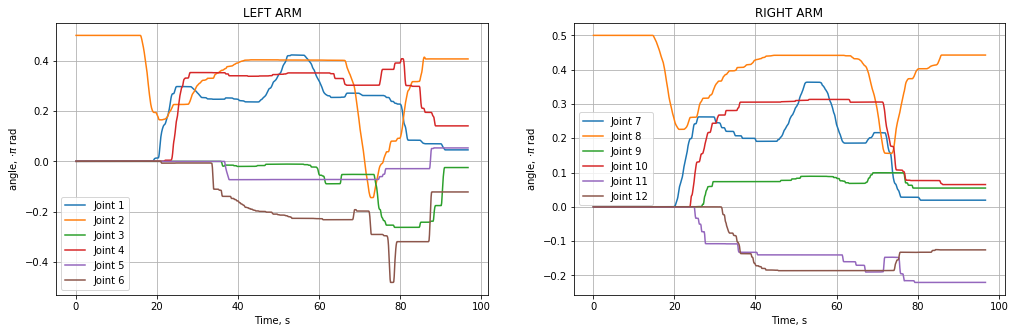

In [13]:
# PLOT THE RECORDED TRAJECTORIES

POS = []

fname = "./joints/motor_rad_"+str("qwe")+".txt"

set_velocity_override(torobo, 50.0)
set_softness_override(torobo, 100.0)
r = rospy.Rate(SRATE) # Hz

with open(fname) as f:
    for line in f:
        positions = [float(i) for i in line.split('\t')]
        POS.append(positions)
POS = np.stack(POS)
POS = np.delete(POS, 0, axis=0)

plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
for i in range(6):
    plt.plot(POS[:,-1], POS[:,i]/np.pi, label='Joint {}'.format(i+1))
plt.xlabel('Time, s')
plt.ylabel('angle, $\cdot \pi$ rad')
plt.legend()
plt.grid()
plt.title('LEFT ARM')

plt.subplot(1,2,2)
for i in range(6,12):
    plt.plot(POS[:,-1], POS[:,i]/np.pi, label='Joint {}'.format(i+1))
plt.xlabel('Time, s')
plt.ylabel('angle, $\cdot \pi$ rad')
plt.legend()
plt.grid()
plt.title('RIGHT ARM')

In [3]:
%%capture
"""
RETURN THE ROBOT TO HOME POSITION
"""
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
servo_on(torobo)
time.sleep(2)
move_homepos(torobo)
print('Robot back to home postion')

In [186]:
%%time

set_velocity_override(torobo, 50.0)
set_softness_override(torobo, 100.0)
r = rospy.Rate(SRATE) # Hz


tt = time.time()
"""
REPLAY THE TRAJECTORY
"""
move_homepos(torobo)

start_t = 10.0
stop_t = 100.0

start_idx = np.abs(POS[:,-1] - start_t).argmin()
stop_idx = np.abs(POS[:,-1] - stop_t).argmin()
print(start_idx, stop_idx)

start = time.time()

for i in range(start_idx, stop_idx):
    left_arm_positions = POS[i, 0:6]
    right_arm_positions = POS[i, 6:12]
    try:
        duration = POS[i+1, -1] - POS[i, -1]
        torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=1)
        torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=1)
        r.sleep() 
        print('pos: {:.4f}\t rec time: {:.6f}\t realtime: {:.6f} \t duration: {:.4f}'.format(
            POS[i, 5],
            POS[i, -1],
            time.time()-start+POS[start_idx,-1],
            duration))
    except:
        break

# servo_off(torobo)
print(time.time() - tt)

[INFO] [1591179831.993775]: set_robot_controller_parameter service client is called
[INFO] [1591179831.996412]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591179831.996776]: set_robot_controller_parameter service client is called
[INFO] [1591179831.998563]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591179831.999056]: set_robot_controller_parameter service client is called
[INFO] [1591179832.000956]: set [velocity_override, ['50.0'], ['all']] is succeeded
[INFO] [1591179832.001264]: set_robot_controller_parameter service client is called
[INFO] [1591179832.002931]: set [softness_override, ['100.0'], ['all']] is succeeded
[INFO] [1591179832.003220]: set_robot_controller_parameter service client is called
[INFO] [1591179832.004525]: set [softness_override, ['100.0'], ['all']] is succeeded
[INFO] [1591179832.004777]: set_robot_controller_parameter service client is called
[INFO] [1591179832.006026]: set [softness_override, ['100.0'], ['all']] is

pos: -0.0211	 rec time: 30.000207	 realtime: 30.006021 	 duration: 0.1000
pos: -0.0211	 rec time: 30.100181	 realtime: 30.106041 	 duration: 0.1000
pos: -0.0211	 rec time: 30.200141	 realtime: 30.206047 	 duration: 0.1000
pos: -0.0211	 rec time: 30.300143	 realtime: 30.306041 	 duration: 0.1000
pos: -0.0211	 rec time: 30.400152	 realtime: 30.406040 	 duration: 0.1000
pos: -0.0211	 rec time: 30.500158	 realtime: 30.506049 	 duration: 0.1000
pos: -0.0211	 rec time: 30.600136	 realtime: 30.606037 	 duration: 0.1000
pos: -0.0211	 rec time: 30.700148	 realtime: 30.706087 	 duration: 0.1000
pos: -0.0211	 rec time: 30.800158	 realtime: 30.806136 	 duration: 0.1000
pos: -0.0211	 rec time: 30.900196	 realtime: 30.906058 	 duration: 0.0999
pos: -0.0211	 rec time: 31.000142	 realtime: 31.006040 	 duration: 0.1000
pos: -0.0211	 rec time: 31.100159	 realtime: 31.105987 	 duration: 0.1000
pos: -0.0211	 rec time: 31.200150	 realtime: 31.206039 	 duration: 0.0999
pos: -0.0211	 rec time: 31.300072	 rea

pos: -0.5445	 rec time: 41.300142	 realtime: 41.306016 	 duration: 0.1000
pos: -0.5480	 rec time: 41.400153	 realtime: 41.406033 	 duration: 0.1000
pos: -0.5490	 rec time: 41.500121	 realtime: 41.506097 	 duration: 0.1000
pos: -0.5578	 rec time: 41.600121	 realtime: 41.606022 	 duration: 0.1000
pos: -0.5679	 rec time: 41.700109	 realtime: 41.706036 	 duration: 0.1000
pos: -0.5737	 rec time: 41.800118	 realtime: 41.806060 	 duration: 0.1000
pos: -0.5737	 rec time: 41.900156	 realtime: 41.906060 	 duration: 0.1000
pos: -0.5737	 rec time: 42.000164	 realtime: 42.006046 	 duration: 0.0999
pos: -0.5740	 rec time: 42.100085	 realtime: 42.106062 	 duration: 0.1000
pos: -0.5756	 rec time: 42.200098	 realtime: 42.206054 	 duration: 0.1000
pos: -0.5787	 rec time: 42.300050	 realtime: 42.306041 	 duration: 0.1001
pos: -0.5797	 rec time: 42.400158	 realtime: 42.406099 	 duration: 0.1000
pos: -0.5797	 rec time: 42.500130	 realtime: 42.506084 	 duration: 0.1000
pos: -0.5809	 rec time: 42.600157	 rea

pos: -0.6877	 rec time: 52.400124	 realtime: 52.406047 	 duration: 0.0999
pos: -0.6908	 rec time: 52.500038	 realtime: 52.506048 	 duration: 0.1001
pos: -0.6915	 rec time: 52.600144	 realtime: 52.606042 	 duration: 0.1000
pos: -0.6920	 rec time: 52.700122	 realtime: 52.706037 	 duration: 0.1000
pos: -0.6920	 rec time: 52.800116	 realtime: 52.806081 	 duration: 0.0999
pos: -0.6927	 rec time: 52.900034	 realtime: 52.906070 	 duration: 0.1001
pos: -0.6973	 rec time: 53.000118	 realtime: 53.006078 	 duration: 0.1000
pos: -0.6975	 rec time: 53.100118	 realtime: 53.106039 	 duration: 0.1000
pos: -0.7007	 rec time: 53.200116	 realtime: 53.206049 	 duration: 0.1000
pos: -0.7112	 rec time: 53.300116	 realtime: 53.306019 	 duration: 0.1000
pos: -0.7113	 rec time: 53.400123	 realtime: 53.406052 	 duration: 0.1000
pos: -0.7113	 rec time: 53.500118	 realtime: 53.506023 	 duration: 0.1000
pos: -0.7113	 rec time: 53.600150	 realtime: 53.606050 	 duration: 0.1000
pos: -0.7113	 rec time: 53.700115	 rea

pos: -0.7284	 rec time: 63.500050	 realtime: 63.506050 	 duration: 0.1000
pos: -0.7284	 rec time: 63.600078	 realtime: 63.606086 	 duration: 0.1001
pos: -0.7284	 rec time: 63.700136	 realtime: 63.706000 	 duration: 0.1000
pos: -0.7282	 rec time: 63.800174	 realtime: 63.806050 	 duration: 0.1001
pos: -0.7282	 rec time: 63.900314	 realtime: 63.906043 	 duration: 0.0998
pos: -0.7282	 rec time: 64.000158	 realtime: 64.006105 	 duration: 0.1000
pos: -0.7282	 rec time: 64.100129	 realtime: 64.106013 	 duration: 0.1000
pos: -0.7282	 rec time: 64.200121	 realtime: 64.206050 	 duration: 0.1000
pos: -0.7282	 rec time: 64.300088	 realtime: 64.306049 	 duration: 0.1000
pos: -0.7282	 rec time: 64.400078	 realtime: 64.406075 	 duration: 0.0999
pos: -0.7282	 rec time: 64.500016	 realtime: 64.506062 	 duration: 0.1001
pos: -0.7282	 rec time: 64.600118	 realtime: 64.606068 	 duration: 0.1001
pos: -0.7281	 rec time: 64.700174	 realtime: 64.706044 	 duration: 0.1000
pos: -0.7281	 rec time: 64.800176	 rea

pos: -0.9122	 rec time: 74.800150	 realtime: 74.806064 	 duration: 0.1000
pos: -0.9122	 rec time: 74.900126	 realtime: 74.906044 	 duration: 0.1000
pos: -0.9122	 rec time: 75.000121	 realtime: 75.006082 	 duration: 0.1000
pos: -0.9122	 rec time: 75.100071	 realtime: 75.106047 	 duration: 0.1000
pos: -0.9122	 rec time: 75.200113	 realtime: 75.206052 	 duration: 0.1000
pos: -0.9122	 rec time: 75.300104	 realtime: 75.306057 	 duration: 0.1000
pos: -0.9122	 rec time: 75.400154	 realtime: 75.406049 	 duration: 0.1000
pos: -0.9122	 rec time: 75.500132	 realtime: 75.506046 	 duration: 0.1000
pos: -0.9122	 rec time: 75.600099	 realtime: 75.606074 	 duration: 0.1000
pos: -0.9145	 rec time: 75.700125	 realtime: 75.706064 	 duration: 0.1000
pos: -0.9175	 rec time: 75.800138	 realtime: 75.806064 	 duration: 0.1001
pos: -0.9246	 rec time: 75.900256	 realtime: 75.906094 	 duration: 0.0999
pos: -0.9276	 rec time: 76.000128	 realtime: 76.006049 	 duration: 0.1000
pos: -0.9277	 rec time: 76.100175	 rea

pos: -1.0026	 rec time: 86.100225	 realtime: 86.106047 	 duration: 0.0999
pos: -1.0026	 rec time: 86.200140	 realtime: 86.206064 	 duration: 0.1000
pos: -1.0026	 rec time: 86.300182	 realtime: 86.306094 	 duration: 0.0999
pos: -1.0026	 rec time: 86.400129	 realtime: 86.406061 	 duration: 0.1000
pos: -1.0026	 rec time: 86.500127	 realtime: 86.506040 	 duration: 0.1000
pos: -1.0026	 rec time: 86.600124	 realtime: 86.606057 	 duration: 0.0999
pos: -1.0026	 rec time: 86.700060	 realtime: 86.706039 	 duration: 0.1000
pos: -1.0025	 rec time: 86.800090	 realtime: 86.806062 	 duration: 0.1000
pos: -1.0024	 rec time: 86.900127	 realtime: 86.906087 	 duration: 0.1000
pos: -1.0008	 rec time: 87.000135	 realtime: 87.006044 	 duration: 0.1000
pos: -0.9840	 rec time: 87.100139	 realtime: 87.106054 	 duration: 0.1000
pos: -0.9148	 rec time: 87.200134	 realtime: 87.206062 	 duration: 0.1000
pos: -0.7974	 rec time: 87.300126	 realtime: 87.306015 	 duration: 0.1000
pos: -0.6664	 rec time: 87.400153	 rea

In [8]:
get_cur_joints(torobo)[0]

[51.42625624144264,
 68.63705364711946,
 34.697799891501845,
 101.20794287275675,
 -73.3069882214852,
 -47.496994053269525,
 51.43327840391924,
 68.28205195463195,
 34.46779331165664,
 101.21994172681013,
 -73.38199841610991,
 -46.73299447516828,
 -0.00026470590011808126,
 -0.0001946117566440627,
 0.0002544514990613456,
 0.0003063089097590296]

# video recorder

In [3]:
plt.switch_backend('TkAgg')
vid_rec = CaptureVid(10)
vid_rec.start()

VIDEO Recording is ON


In [ ]:
vid_rec.stop()
del vid_rec

# CV2 IMSHOW DICE FOLLOWING IN A THREAD

In [5]:
"""THIS CELL RUNS EVERYTHING IN A SEPARATE THREAD: SUBSCRIBER THAT STORES VIDEO FRAMES EVERY TIME STEP `IMAGEBUFF`
   AND UPDATES BOUNDING BOXES AROUND THE OBJECT USING CV2 IMSHOW"""

plt.switch_backend('TkAgg')

sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
from detect_upd import Recog, Recog2
import random
# recog = Recog()

checkpoint = 42
recog = Recog2(checkpoint)
# torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')

class CV2im(threading.Thread):
    
    def __init__(self):
        s = 'wqerqasdfoiuymnmnbv'
        self.wname = ''.join(random.sample(s,len(s)))
        threading.Thread.__init__(self)
        self.imagebuff = 0
        time.sleep(1)
        self.keepgoing = False
        rospy.Subscriber("/camera/color/image_raw", Image, self.image_callback)
        time.sleep(1)
        self.T = []
        
        
    def image_callback(self, msg):
        self.imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8")

    def stop(self):
        self.keepgoing = False
        
    def get_gaze_offset(self, cx, cy):
        return 640/2 - cx, 480/2 - cy

    def get_gaze_grad(self, offset_x, offset_y):
        ex = 0.2 * np.tanh(0.025*(offset_x))
        ey = 0.2 * np.tanh(0.025*(offset_y))
        return ex, ey

    def get_box_center(self, x1, y1, box_w, box_h):
        return x1 + box_w/2, y1 + box_h/2
    
    def track_obj(self, x,y,w,h):
        global torobo
        cx, cy = self.get_box_center(x, y, w, h)
        gaze_offset = self.get_gaze_offset(cx,cy)
        ex, ey = self.get_gaze_grad(*gaze_offset)
        hor, ver = get_cur_joints(torobo)[0][14:16]
        torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                      joint_ids = [2, 3],
                      positions=[np.radians(hor)+ex, np.radians(ver)-ey],
                      velocities=None,
                      accelerations=None,
                      duration=1.0)
#         torobo.move(ToroboOperator.TORSO_HEAD, positions=[0, 0, np.radians(hor)+ex, np.radians(ver)-ey], duration=1)
        
    def run(self):
        self.keepgoing = True
        while True and self.keepgoing:
            detections = recog.detect(self.imagebuff)
            if detections is not None:
                for det in detections:
                    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                        if cls_pred == 0:
                            box_w = x2 - x1
                            box_h = y2 - y1
                            image = cv2.rectangle(self.imagebuff, (x1,y1), (x2,y2), (255, 0, 0), 3)
                            x, y, w, h = x1, y1, box_w, box_h
                            self.track_obj(x, y, w, h)
            cv2.imshow(self.wname, cv2.cvtColor(self.imagebuff, cv2.COLOR_RGB2BGR))
            
            k = cv2.waitKey(3) & 0XFF
            if k== 27 :
                break
            self.T.append(time.time())
        cv2.waitKey(1)
        cv2.destroyWindow(self.wname)
        cv2.waitKey(1)

cv2im = CV2im()
cv2im.start()

In [6]:
cv2im.is_alive()

True

In [ ]:
cv2im.stop()
cv2im.join()

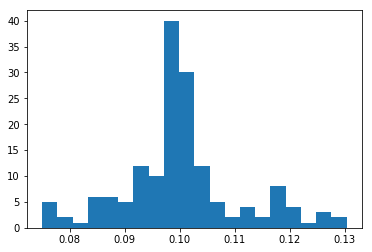

In [20]:
%matplotlib inline
x = plt.hist(np.diff(T), bins=20)

# PLT IMSHOW DICE FOLLOWING THROUGH A GLOBAL VAR

<IPython.core.display.Javascript object>


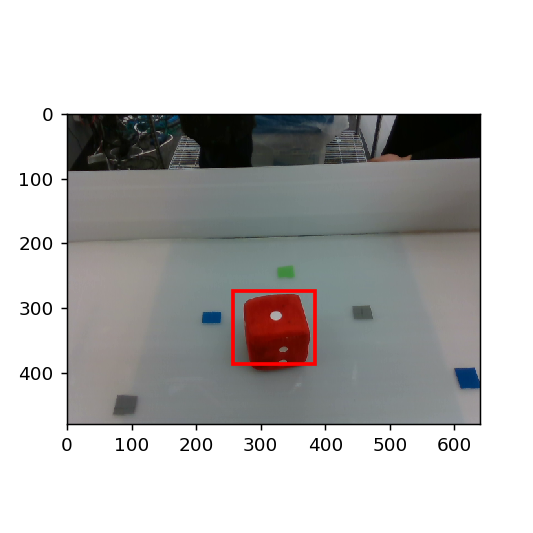

In [33]:
%matplotlib notebook

"""THIS CELL CREATES SUBSCRIBER THAT STORES VIDEO FRAMES EVERY TIME STEP INTO A GLOBAL VARIABLE `IMAGEBUFF`
   AND UPDATES BOUNDING BOXES AROUND THE OBJECT USING MATPLOTLIB ANIMATION"""

sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
# from detect_upd import Recog
# recog = Recog()

from detect_upd import Recog2
checkpoint = 42
recog = Recog2(checkpoint)
# torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')

def get_gaze_offset(cx, cy):
    return 640/2 - cx, 480/2 - cy

def get_gaze_grad(offset_x, offset_y):
    ex = 0.2 * np.tanh(0.025*(offset_x))
    ey = 0.2 * np.tanh(0.025*(offset_y))
    return ex, ey

def get_box_center(x1, y1, box_w, box_h):
    return x1 + box_w/2, y1 + box_h/2

def track_obj(x,y,w,h):
    global torobo
    cx, cy = get_box_center(x, y, w, h)
    gaze_offset = get_gaze_offset(cx,cy)
    ex, ey = get_gaze_grad(*gaze_offset)
    hor, ver = get_cur_joints(torobo)[0][14:16]
    torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                      joint_ids = [2, 3],
                      positions=[np.radians(hor)+ex, np.radians(ver)-ey],
                      velocities=None,
                      accelerations=None,
                      duration=1.0)
#     torobo.move(ToroboOperator.TORSO_HEAD, positions=[0, 0, np.radians(hor)+ex, np.radians(ver)-ey], duration=1)
    
    
if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)


figure = plt.figure(figsize=(4,4))
ax = plt.gca()
im = ax.imshow(imagebuff)

   
T = []
def update(frame):
    global T, recog, im, ax, imagebuff
    
    [p.remove() for p in reversed(ax.patches)]
    
    detections = recog.detect(imagebuff)
    im.set_data(imagebuff)
    if detections is not None:
        for det in detections:
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                if cls_pred == 0:
                    box_w = x2 - x1
                    box_h = y2 - y1

                    x, y, w, h = x1, y1, box_w, box_h

                    # Create a Rectangle patch
                    bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r',facecolor='none')
                    ax.add_patch(bbox)
                    track_obj(x, y, w, h)

        T.append(time.time())
    return im,


animation = FuncAnimation(figure, update, interval=10, blit=True)

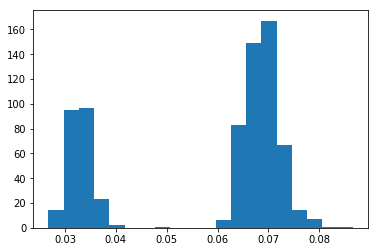

In [8]:
%matplotlib inline
x = plt.hist(np.diff(T), bins=20)

<IPython.core.display.Javascript object>


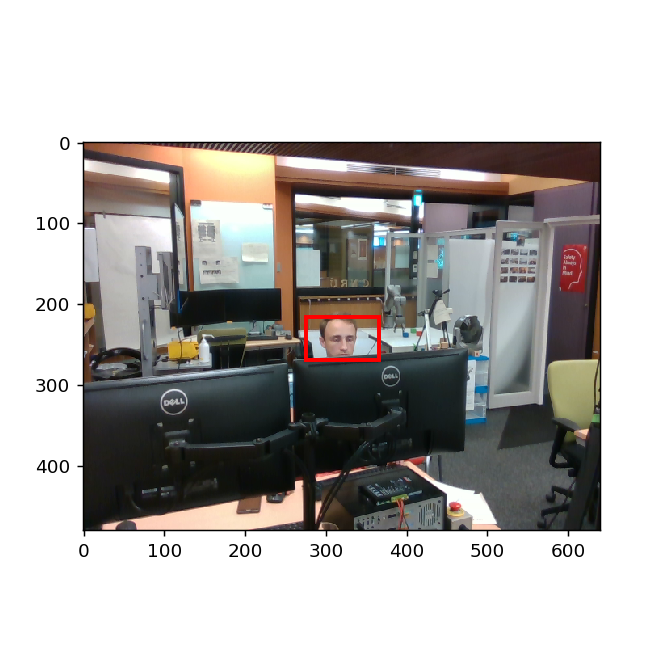

In [8]:
"""THIS CELL CREATES AND DESTROYS SUBSCRIBER EVERY TIME STEP
   AND UPDATES BOUNDING BOXES AROUND THE OBJECT USING MATPLOTLIB ANIMATION"""

%matplotlib notebook
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from detect_upd import Recog

recog = Recog()

figure = plt.figure(figsize=(5,5))
ax = plt.gca()

image_topic = "/camera/color/image_raw" # Real-Robot
msg = rospy.wait_for_message(image_topic, Image)
cv2_img = bridge.imgmsg_to_cv2(msg, "rgb8")
im = ax.imshow(cv2_img)

r = rospy.Rate(50)
                
T = []
def update(frame):
    global T, recog, im, ax
    
    [p.remove() for p in reversed(ax.patches)]
    
    t = time.time()
    msg = rospy.wait_for_message(image_topic, Image)
    cv2_img = bridge.imgmsg_to_cv2(msg, "rgb8")
    detections = recog.detect(cv2_img)
    im.set_data(cv2_img)
    for det in detections:
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            if cls_pred==0:
                box_w = x2 - x1
                box_h = y2 - y1
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='r',facecolor='none')
                ax.add_patch(bbox)

    T.append(time.time())
    return im,

animation = FuncAnimation(figure, update, interval=10, blit=True)

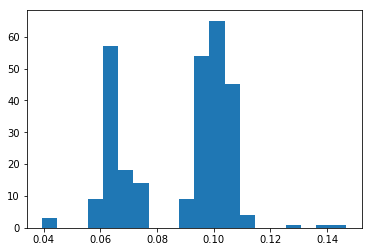

In [9]:
%matplotlib inline
x = plt.hist(np.diff(T), bins=20)

## THIS CELL DOES THE SAME AS ABOVE, ONLY ONE TIME

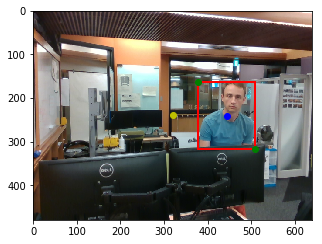

In [116]:
%matplotlib inline

sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from detect_upd import Recog

def get_gaze_offset(cx, cy):
    return 640/2 - cx, 480/2 - cy

def get_gaze_grad(offset_x, offset_y):
    ex = 0.1 * np.tanh(0.025*(offset_x))
    ey = 0.1 * np.tanh(0.025*(offset_y))
    return ex, ey

def get_box_center(x1, y1, box_w, box_h):
    return x1 + box_w/2, y1 + box_h/2


recog = Recog()

figure = plt.figure(figsize=(5,5))
ax = plt.gca()

image_topic = "/camera/color/image_raw" # Real-Robot

msg = rospy.wait_for_message(image_topic, Image)
cv2_img = bridge.imgmsg_to_cv2(msg, "rgb8")
im = ax.imshow(cv2_img)

msg = rospy.wait_for_message(image_topic, Image)
cv2_img = bridge.imgmsg_to_cv2(msg, "rgb8")
detections = recog.detect(cv2_img)
im.set_data(cv2_img)
for det in detections:
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        if cls_pred == 0:
            box_w = x2 - x1
            box_h = y2 - y1
            
            x, y, w, h = x1, y1, box_w, box_h
            
            # Create a Rectangle patch
            bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r',facecolor='none')
            ax.add_patch(bbox)
            
            cx, cy = get_box_center(x, y, w, h)
            gaze_offset = get_gaze_offset(cx,cy)
            ex, ey = get_gaze_grad(*gaze_offset)
            hor, ver = get_cur_joints(torobo)[0][14:16]
            torobo.move(ToroboOperator.TORSO_HEAD, positions=[0, 0, np.radians(hor)+ex, np.radians(ver)-ey], duration=3)

            
plt.plot(x,y, 'go')
plt.plot(x+w,y+h, 'go')

cx, cy = get_box_center(x, y, box_w, box_h)
plt.plot(cx,cy, 'bo')
plt.plot(640/2, 480/2, 'yo')


In [78]:
""" THIS CV2 IMSHOW WINDOW OPENS ON TOP AND NEVER DIES """
cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


while True:
    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break